#Imports

In [69]:
! pip install pandas-ta

In [70]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

In [71]:
#model imports
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

# Load Data

In [72]:
#Combine and load the datas into one csv to be processed
df1 = pd.read_csv('merged_technology_news_data_future_3months.csv')
df2 = pd.read_csv('technology_news_data_50Daily.csv')
df3 = pd.read_csv('1201-1210_news_data.csv')

# Combine the dataframes by row
df_combined = pd.concat([df1, df2, df3], ignore_index=True)
df_combined = df_combined.sort_values(by='time_published', ascending=True).reset_index(drop=True)

# Optional: Save the combined dataframe to a new CSV file
df_combined.to_csv('combined_file.csv', index=False)
display(df_combined)

,title,url,time_published,source,overall_sentiment_score,overall_sentiment_label,ticker_sentiment
0,CNH Industrial: Periodic Report on $300 Millio...,https://www.globenewswire.com/news-release/202...,2023-09-01 20:30:00,GlobeNewswire,0.312457,Somewhat-Bullish,"[{'ticker': 'RGBD', 'relevance_score': '0.0986..."
1,Sono Group Receives Additional Staff Determina...,https://www.globenewswire.com/news-release/202...,2023-09-01 20:30:00,GlobeNewswire,0.047543,Neutral,"[{'ticker': 'SEV', 'relevance_score': '0.10945..."
2,CytoSorbents Announces Resignation of Chief Fi...,https://www.globenewswire.com/news-release/202...,2023-09-01 20:43:00,GlobeNewswire,0.121210,Neutral,"[{'ticker': 'META', 'relevance_score': '0.0735..."
3,CytoSorbents Announces Resignation of Chief Fi...,https://www.benzinga.com/pressreleases/23/09/g...,2023-09-01 20:43:18,Benzinga,0.116318,Neutral,"[{'ticker': 'META', 'relevance_score': '0.0709..."
4,Positioning for a Year End Rally: 3 Top Ranked...,https://www.zacks.com/commentary/2143938/posit...,2023-09-01 20:45:00,Zacks Commentary,0.296182,Somewhat-Bullish,"[{'ticker': 'LRCX', 'relevance_score': '0.2589..."
...,...,...,...,...,...,...,...
23345,Google's New Willow Chip Accelerates Time to M...,https://decrypt.co/295678/googles-new-willow-c...,2024-12-09 23:34:55,Decrypt.co,0.079230,Neutral,"[{'ticker': 'MSFT', 'relevance_score': '0.0627..."
23346,"Five9, Inc. Shareholder Notice: Robbins LLP Re...",https://www.benzinga.com/pressreleases/24/12/g...,2024-12-09 23:50:42,Benzinga,0.053073,Neutral,"[{'ticker': 'FIVN', 'relevance_score': '0.5914..."
23347,"Five9, Inc. Shareholder Notice: Robbins LLP Re...",https://www.benzinga.com/pressreleases/24/12/g...,2024-12-09 23:50:42,Benzinga,0.053073,Neutral,"[{'ticker': 'FIVN', 'relevance_score': '0.5914..."
23348,Bitcoin and Ethereum ETFs Add Billions Amid Re...,https://decrypt.co/295733/bitcoin-and-ethereum...,2024-12-10 00:50:23,Decrypt.co,0.168180,Somewhat-Bullish,"[{'ticker': 'MSTR', 'relevance_score': '0.1529..."


# Define functions to use for creating and processing the dataset

In [73]:
def create_processed_data_df(start, end, ticker, sentiment_csv, daysInAdvance=5):
  stock_df = yf.download(ticker, start=start, end=end)
  stock_df = stock_df.xs(ticker, level='Ticker', axis=1)
  stock_df['time_published'] = stock_df.index
  stock_df['time_published'] = pd.to_datetime(stock_df['time_published'])
  stock_df['time_published'] = stock_df['time_published'].dt.date

  #Adding indicators
  stock_df['RSI']=ta.rsi(stock_df.Close, length=15)
  stock_df['EMAF']=ta.ema(stock_df.Close, length=20)
  stock_df['EMAM']=ta.ema(stock_df.Close, length=100)
  stock_df['EMAS']=ta.ema(stock_df.Close, length=150)
  display(stock_df)

  stock_df['Target'] = stock_df['Adj Close']-stock_df.Open
  stock_df['Target'] = stock_df['Target'].shift(-1)

  stock_df['TargetClass'] = [1 if stock_df.Target[i]>0 else 0 for i in range(len(stock_df))]

  stock_df['TargetNextClose'] = stock_df['Adj Close'].shift(-1)
  for i in range(2, daysInAdvance+1):
    stock_df[f'TargetCloseIn{i}Days'] = stock_df['Adj Close'].shift(-i)

  second_last_row = stock_df.iloc[[-2]]
  stock_df.dropna(inplace=True)
  stock_df.reset_index(inplace = True)
  stock_df = pd.concat([stock_df, second_last_row], ignore_index=True)
  stock_df.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)



  news_df = pd.read_csv(sentiment_csv)
  news_df['time_published'] = pd.to_datetime(news_df['time_published'])
  news_df['time_published'] = news_df['time_published'].dt.date
  news_df = news_df[news_df['title'] != 'Before you continue']


  df1 = stock_df.copy(deep=True)
  df2 = news_df[['time_published', 'source', 'overall_sentiment_score']]
  average_sentiment_df = df2.groupby(['time_published', 'source'], as_index=False)['overall_sentiment_score'].mean()
  average_sentiment_df.rename(columns={'overall_sentiment_score': 'average sentiment score'}, inplace=True)
  pivot_df = average_sentiment_df.pivot(index='time_published', columns='source', values='average sentiment score')
  pivot_df.reset_index(inplace=True)
  pivot_df.fillna(-1, inplace=True)
  pivot_df.replace(-1, np.nan, inplace=True)
  combined_df = pd.merge(df1, pivot_df, on='time_published', how='inner')

  # List of columns representing sentiment scores
  news_sentiment_columns = combined_df.drop(['Adj Close', 'High', 'Low', 'Open', 'time_published', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'Target', 'TargetClass', 'TargetNextClose']+[f'TargetCloseIn{i}Days' for i in range(2, daysInAdvance+1)], axis=1).columns.tolist()

  # Calculate the mean sentiment across all news sources
  combined_df['aggregate_sentiment_mean'] = combined_df[news_sentiment_columns].mean(axis=1)

  # Calculate other possible aggregation metrics (optional)
  combined_df['aggregate_sentiment_median'] = combined_df[news_sentiment_columns].median(axis=1)
  combined_df['aggregate_sentiment_std'] = combined_df[news_sentiment_columns].std(axis=1)

  # Fill missing values with 0 before aggregation
  combined_df[news_sentiment_columns] = combined_df[news_sentiment_columns].fillna(0)

  # Recalculate the mean sentiment
  combined_df['aggregate_sentiment_mean'] = combined_df[news_sentiment_columns].mean(axis=1)

  # combined_df = combined_df.iloc[:-1]

  # print(combined_df[['time_published', 'aggregate_sentiment_mean']].head())
  final_df = combined_df[['Adj Close', 'High', 'Low', 'Open', "RSI", "EMAF", "EMAM", "EMAS", 'aggregate_sentiment_mean', 'aggregate_sentiment_median', 'aggregate_sentiment_std', 'Target', 'TargetClass', 'TargetNextClose']+[f'TargetCloseIn{i}Days' for i in range(2, daysInAdvance+1)]]
  second_last_row, second_last_row_date = final_df.iloc[[-1]], combined_df.iloc[[-1]]['time_published'].values
  time_published = combined_df['time_published'].values
  # final_df = combined_df[['Adj Close', 'High', 'Low', 'Open', 'Target', 'TargetClass', 'TargetNextClose']]


  data_set = final_df.iloc[:, 0:11]#.values
  pd.set_option('display.max_columns', None)

  return final_df, time_published, (second_last_row, second_last_row_date) #Second last row is kept instead of dropped to predict future dates

In [74]:
def create_scaled_dataset(df,  time_published, MinMaxScaler=MinMaxScaler, backcandles=30, num_features=11, daysInAdvance=5):
  sc = MinMaxScaler(feature_range=(0,1))
  # data_set_scaled = sc.fit_transform(data_set)
  # print(data_set_scaled)
  data_set = df.to_numpy()
  # multiple feature from data provided to the model
  X = []
  corresponding_times = []
  print(data_set.shape[0])
  for j in range(num_features):#data_set[0].size):#2 excluding targets
      X.append([])
      for i in range(backcandles, data_set.shape[0]):#backcandles+2
          X[j].append(data_set[i-backcandles:i, j])

  for i in range(backcandles, data_set.shape[0]):  # Starting from backcandles to get the correct times
    # Append the time corresponding to the last time step of each sample
    corresponding_times.append(time_published[i])
  corresponding_times = np.array(corresponding_times)


  #move axis from 0 to position 2
  X=np.moveaxis(X, [0], [2])

  #Erase first elements of y because of backcandles to match X length
  X, yi =np.array(X), np.array(data_set[backcandles:,-daysInAdvance:])
  y=np.reshape(yi,(len(yi),daysInAdvance))
  # print(X)
  print(X.shape)
  # print(y)
  print(y.shape)

  from sklearn.preprocessing import MinMaxScaler
  sc_X = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))

  X_shape = X.shape
  X_reshaped = X.reshape(-1, X.shape[2])

  X_reshaped_scaled = sc_X.fit_transform(X_reshaped)
  X = X_reshaped_scaled.reshape(X_shape[0], X_shape[1], -1)
  y = sc_y.fit_transform(y)
  return X, y, sc_X, sc_y, corresponding_times

In [75]:
def lstm_model(backcandles, X_train, y_train, epochs, num_features, daysInAdvance):
  np.random.seed(506)
  tf.random.set_seed(506)

  lstm_input = Input(shape=(backcandles, num_features), name='lstm_input')
  inputs = LSTM(150, name='first_layer')(lstm_input)
  inputs = Dense(daysInAdvance, name='dense_layer')(inputs)
  output = Activation('linear', name='output')(inputs)
  model = Model(inputs=lstm_input, outputs=output)
  adam = optimizers.Adam()
  model.compile(optimizer=adam, loss='mse')
  model.fit(x=X_train, y=y_train, batch_size=15, epochs=epochs, shuffle=True, validation_split = 0.1)
  return model

# Create Datasets

# Create 1 Day in Advance Dataset

In [76]:
final_df_1Day, time_published_1Day, (second_last_row_1Day, second_last_row_date_1Day) = create_processed_data_df("2023-09-01", "2024-12-10", "QQQ", 'combined_file.csv', daysInAdvance=1)
display(final_df_1Day)

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,time_published,RSI,EMAF,EMAM,EMAS
Date,,,,,,,,,,,
2023-09-01,374.475830,377.589996,380.829987,376.079987,380.399994,39772400,2023-09-01,NaN,NaN,NaN,NaN
2023-09-05,374.951904,378.070007,379.309998,375.829987,376.769989,32344200,2023-09-05,NaN,NaN,NaN,NaN
2023-09-06,371.649384,374.739990,377.630005,372.700012,377.279999,42998700,2023-09-06,NaN,NaN,NaN,NaN
2023-09-07,368.991486,372.059998,372.850006,369.149994,370.209991,52060700,2023-09-07,NaN,NaN,NaN,NaN
2023-09-08,369.507202,372.579987,374.850006,371.600006,372.010010,35800100,2023-09-08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-03,516.869995,516.869995,517.150024,513.369995,513.950012,18597900,2024-12-03,64.044899,506.060371,485.863898,474.718866
2024-12-04,523.260010,523.260010,523.520020,519.599976,520.320007,26086200,2024-12-04,68.222767,507.698432,486.604415,475.361795
2024-12-05,521.809998,521.809998,524.039978,521.419983,523.309998,18169600,2024-12-05,66.348388,509.042390,487.301555,475.977003


<ipython-input-73-e4cdceaa213a>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_df['TargetClass'] = [1 if stock_df.Target[i]>0 else 0 for i in range(len(stock_df))]


,Adj Close,High,Low,Open,RSI,EMAF,EMAM,EMAS,aggregate_sentiment_mean,aggregate_sentiment_median,aggregate_sentiment_std,Target,TargetClass,TargetNextClose
0,439.283508,442.500000,439.200012,441.410004,51.596656,440.755223,417.497347,400.447800,0.056476,0.162014,0.108029,-2.051361,0,440.908630
1,440.908630,443.239990,437.440002,442.959991,53.440418,440.895679,417.987102,401.001207,0.056175,0.143970,0.139817,0.060181,1,437.060181
2,437.060181,439.239990,436.279999,437.000000,48.730694,440.655138,418.390724,401.496157,0.037851,0.162568,0.107070,3.779236,1,444.039246
3,444.039246,446.329987,437.959991,440.260010,56.226364,441.104172,418.924967,402.077268,0.030058,0.121310,0.125926,-4.139557,0,436.960449
4,436.960449,442.239990,436.880005,441.100006,48.517730,440.834250,419.308037,402.556642,0.049813,0.162524,0.070360,-12.287994,0,429.772003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,516.869995,517.150024,513.369995,513.950012,64.044899,506.060371,485.863898,474.718866,0.023589,0.198608,0.050441,2.940002,1,523.260010
167,523.260010,523.520020,519.599976,520.320007,68.222767,507.698432,486.604415,475.361795,0.030685,0.215717,0.093290,-1.500000,0,521.809998
168,521.809998,524.039978,521.419983,523.309998,66.348388,509.042390,487.301555,475.977003,0.021576,0.213241,0.024090,4.000000,1,526.479980
169,526.479980,526.719971,522.349976,522.479980,69.262484,510.703113,488.077365,476.645916,0.032807,0.203452,0.070809,-3.169983,0,522.380005


In [77]:
#Create Datasets
NUM_FEATURES = 11 #Corresponds with the number of features in the dataframe to use for training
X_1Day, y_1Day, sc_X_1Day, sc_y_1Day, corresponding_times_1Day = create_scaled_dataset(final_df_1Day, time_published_1Day, MinMaxScaler, num_features=NUM_FEATURES, daysInAdvance=1)
last_X_1Day, last_y_1Day, last_time_1Day = X_1Day[-1], y_1Day[-1], corresponding_times_1Day[-1]
X_1Day, y_1Day, corresponding_times_1Day = X_1Day[:-1, :, :], y_1Day[:-1], corresponding_times_1Day[:-1]
print(X_1Day.shape, y_1Day.shape)
# split data into train test sets
splitlimit = 92
print(splitlimit)
X_train_1Day, X_test_1Day = X_1Day[:splitlimit], X_1Day[splitlimit:]
y_train_1Day, y_test_1Day = y_1Day[:splitlimit], y_1Day[splitlimit:]
time_published_train_1Day, time_published_test_1Day = corresponding_times_1Day[:splitlimit], corresponding_times_1Day[splitlimit:]
print(X_train_1Day.shape, X_test_1Day.shape)
print(y_train_1Day.shape, y_test_1Day.shape)
print(sc_y_1Day.inverse_transform([y_train_1Day[-1]]), time_published_train_1Day[-1])
print(sc_y_1Day.inverse_transform([y_test_1Day[-1]]), time_published_test_1Day[-1])

171
(141, 30, 11)
(141, 1)
(140, 30, 11) (140, 1)
92
(92, 30, 11) (48, 30, 11)
(92, 1) (48, 1)
[[481.26998901]] 2024-09-30
[[522.38000488]] 2024-12-06



# Create 5 Day Dataset



In [78]:
final_df, time_published, (second_last_row, second_last_row_date) = create_processed_data_df("2023-09-01", "2024-12-10", "QQQ", 'combined_file.csv', daysInAdvance=5)
display(final_df)

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,time_published,RSI,EMAF,EMAM,EMAS
Date,,,,,,,,,,,
2023-09-01,374.475830,377.589996,380.829987,376.079987,380.399994,39772400,2023-09-01,NaN,NaN,NaN,NaN
2023-09-05,374.951904,378.070007,379.309998,375.829987,376.769989,32344200,2023-09-05,NaN,NaN,NaN,NaN
2023-09-06,371.649384,374.739990,377.630005,372.700012,377.279999,42998700,2023-09-06,NaN,NaN,NaN,NaN
2023-09-07,368.991486,372.059998,372.850006,369.149994,370.209991,52060700,2023-09-07,NaN,NaN,NaN,NaN
2023-09-08,369.507202,372.579987,374.850006,371.600006,372.010010,35800100,2023-09-08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-03,516.869995,516.869995,517.150024,513.369995,513.950012,18597900,2024-12-03,64.044899,506.060371,485.863898,474.718866
2024-12-04,523.260010,523.260010,523.520020,519.599976,520.320007,26086200,2024-12-04,68.222767,507.698432,486.604415,475.361795
2024-12-05,521.809998,521.809998,524.039978,521.419983,523.309998,18169600,2024-12-05,66.348388,509.042390,487.301555,475.977003


<ipython-input-73-e4cdceaa213a>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_df['TargetClass'] = [1 if stock_df.Target[i]>0 else 0 for i in range(len(stock_df))]


,Adj Close,High,Low,Open,RSI,EMAF,EMAM,EMAS,aggregate_sentiment_mean,aggregate_sentiment_median,aggregate_sentiment_std,Target,TargetClass,TargetNextClose,TargetCloseIn2Days,TargetCloseIn3Days,TargetCloseIn4Days,TargetCloseIn5Days
0,439.283508,442.500000,439.200012,441.410004,51.596656,440.755223,417.497347,400.447800,0.056476,0.162014,0.108029,-2.051361,0,440.908630,437.060181,444.039246,436.960449,429.772003
1,440.908630,443.239990,437.440002,442.959991,53.440418,440.895679,417.987102,401.001207,0.056175,0.143970,0.139817,0.060181,1,437.060181,444.039246,436.960449,429.772003,429.811890
2,437.060181,439.239990,436.279999,437.000000,48.730694,440.655138,418.390724,401.496157,0.037851,0.162568,0.107070,3.779236,1,444.039246,436.960449,429.772003,429.811890,424.567596
3,444.039246,446.329987,437.959991,440.260010,56.226364,441.104172,418.924967,402.077268,0.030058,0.121310,0.125926,-4.139557,0,436.960449,429.772003,429.811890,424.567596,422.144867
4,436.960449,442.239990,436.880005,441.100006,48.517730,440.834250,419.308037,402.556642,0.049813,0.162524,0.070360,-12.287994,0,429.772003,429.811890,424.567596,422.144867,413.411041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,509.309998,510.140015,507.230011,508.079987,59.506223,502.989146,483.695311,472.683815,0.020275,0.199097,0.051267,-2.870026,0,505.299988,509.739990,515.289978,516.869995,523.260010
163,505.299988,508.239990,501.929993,508.170013,54.825361,503.209226,484.123127,473.115817,0.022794,0.193262,0.174795,3.809998,1,509.739990,515.289978,516.869995,523.260010,521.809998
164,509.739990,510.339996,505.309998,505.929993,58.681145,503.831204,484.630391,473.600906,0.021894,0.176974,0.061483,4.279968,1,515.289978,516.869995,523.260010,521.809998,526.479980
165,515.289978,516.260010,510.619995,511.010010,62.919836,504.922516,485.237512,474.153079,0.023133,0.221688,0.165670,2.919983,1,516.869995,523.260010,521.809998,526.479980,522.380005


In [79]:
#Create Datasets
NUM_FEATURES = 11 #Corresponds with the number of features in the dataframe to use for training
X, y, sc_X, sc_y, corresponding_times = create_scaled_dataset(final_df, time_published, MinMaxScaler, num_features=NUM_FEATURES, daysInAdvance=5)
last_X, last_y, last_time = X[-1], y[-1], corresponding_times[-1]
X, y, corresponding_times = X[:-1, :, :], y[:-1], corresponding_times[:-1]
print(X.shape, y.shape)
# split data into train test sets
splitlimit = 92
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
time_published_train, time_published_test = corresponding_times[:splitlimit], corresponding_times[splitlimit:]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(sc_y.inverse_transform([y_train[-1]]), time_published_train[-1])
print(sc_y.inverse_transform([y_test[-1]]), time_published_test[-1])

167
(137, 30, 11)
(137, 5)
(136, 30, 11) (136, 5)
92
(92, 30, 11) (44, 30, 11)
(92, 5) (44, 5)
[[481.26998901 481.95001221 481.58999634 487.32000732 482.1000061 ]] 2024-09-30
[[516.86999512 523.26000977 521.80999756 526.47998047 522.38000488]] 2024-12-02


# Model

# 1 Day in Advance Model

In [80]:
model_1Day = lstm_model(30, X_train, y_train, 30, NUM_FEATURES, 1)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - loss: 0.1201 - val_loss: 0.0155
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0274 - val_loss: 0.0616
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0255 - val_loss: 0.0104
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0244 - val_loss: 0.0271
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0197 - val_loss: 0.0395
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0195 - val_loss: 0.0191
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0185 - val_loss: 0.0204
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0175 - val_loss: 0.0267
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0172 - val_loss: 0.0188
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0164 - val_loss: 0.0195
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0157 - val_loss: 0.0206
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0150 - val_loss: 0.01

# 5 Day Model

In [81]:
model = lstm_model(30, X_train, y_train, 30, NUM_FEATURES, 5)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.2003 - val_loss: 0.0070
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0491 - val_loss: 0.0356
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0275 - val_loss: 0.0464
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0256 - val_loss: 0.0238
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0216 - val_loss: 0.0194
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0210 - val_loss: 0.0276
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0196 - val_loss: 0.0295
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0191 - val_loss: 0.0256
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0183 - val_loss: 0.0231
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0178 - val_loss: 0.0235
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0171 - val_loss: 0.0233
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0165 - val_loss: 0.0207
E

# Evaluation

# 1 Day in Advance

In [82]:
loss_1Day = model_1Day.evaluate(X_test_1Day, y_test_1Day, verbose=0)
print(f"Mean Squared Error on test set: {loss_1Day}")
y_pred_1Day = model_1Day.predict(X_test_1Day)

Mean Squared Error on test set: 0.18488265573978424
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


# 5 Day

In [83]:
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on test set: {loss}")
y_pred = model.predict(X_test)

Mean Squared Error on test set: 0.07039858400821686
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


# Plots

# 1 Day

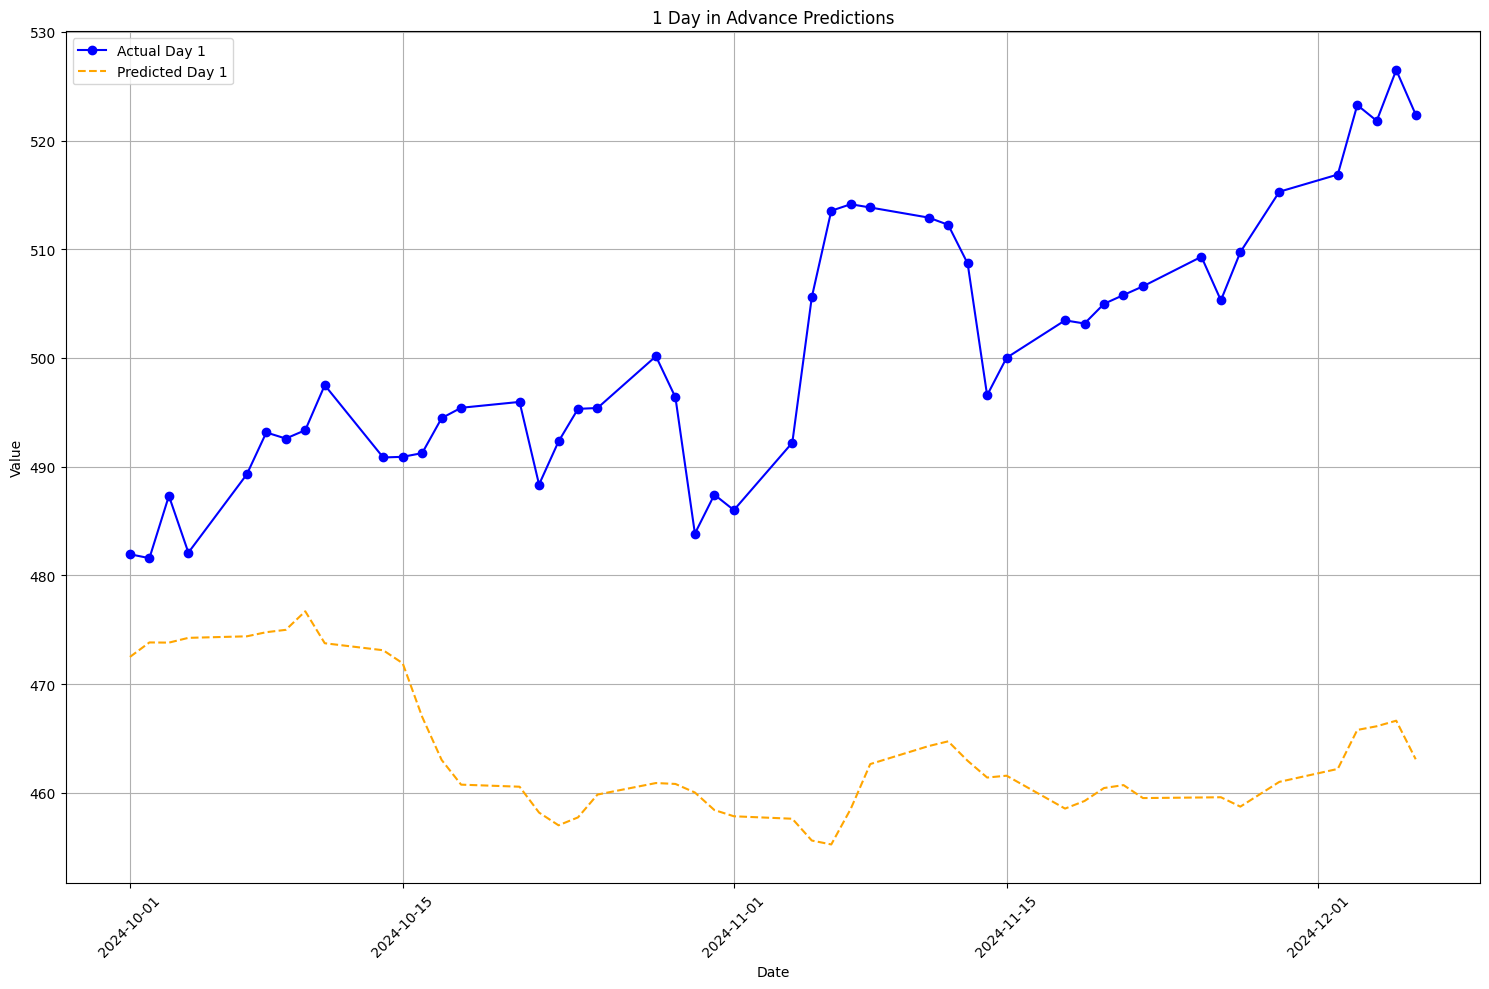

In [84]:
#1 Day Plot
# Assuming test_dates are the dates corresponding to X_test
num_days = 1  # Number of days ahead predictions
test_dates_1Day = pd.DataFrame(time_published_test_1Day)  # Example dates

y_test_original_1Day = sc_y_1Day.inverse_transform(y_test_1Day)
y_pred_original_1Day = sc_y_1Day.inverse_transform(y_pred_1Day)

# Create DataFrames for easier handling
y_test_df_1Day = pd.DataFrame(y_test_original_1Day, index=test_dates_1Day, columns=[f"Day {i+1}" for i in range(num_days)])
y_pred_df_1Day = pd.DataFrame(y_pred_original_1Day, index=test_dates_1Day, columns=[f"Day {i+1}" for i in range(num_days)])

# Plot each day individually
plt.figure(figsize=(15, 10))

plt.xticks(rotation=45)
plt.plot(test_dates_1Day, y_test_df_1Day.iloc[:, 0], label=f"Actual Day {1}", color="blue", linestyle="-", marker="o")
plt.plot(test_dates_1Day, y_pred_df_1Day.iloc[:, 0], label=f"Predicted Day {0+1}", color="orange", linestyle="--")
plt.title(f"{0+1} Day in Advance Predictions")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# 5 Day

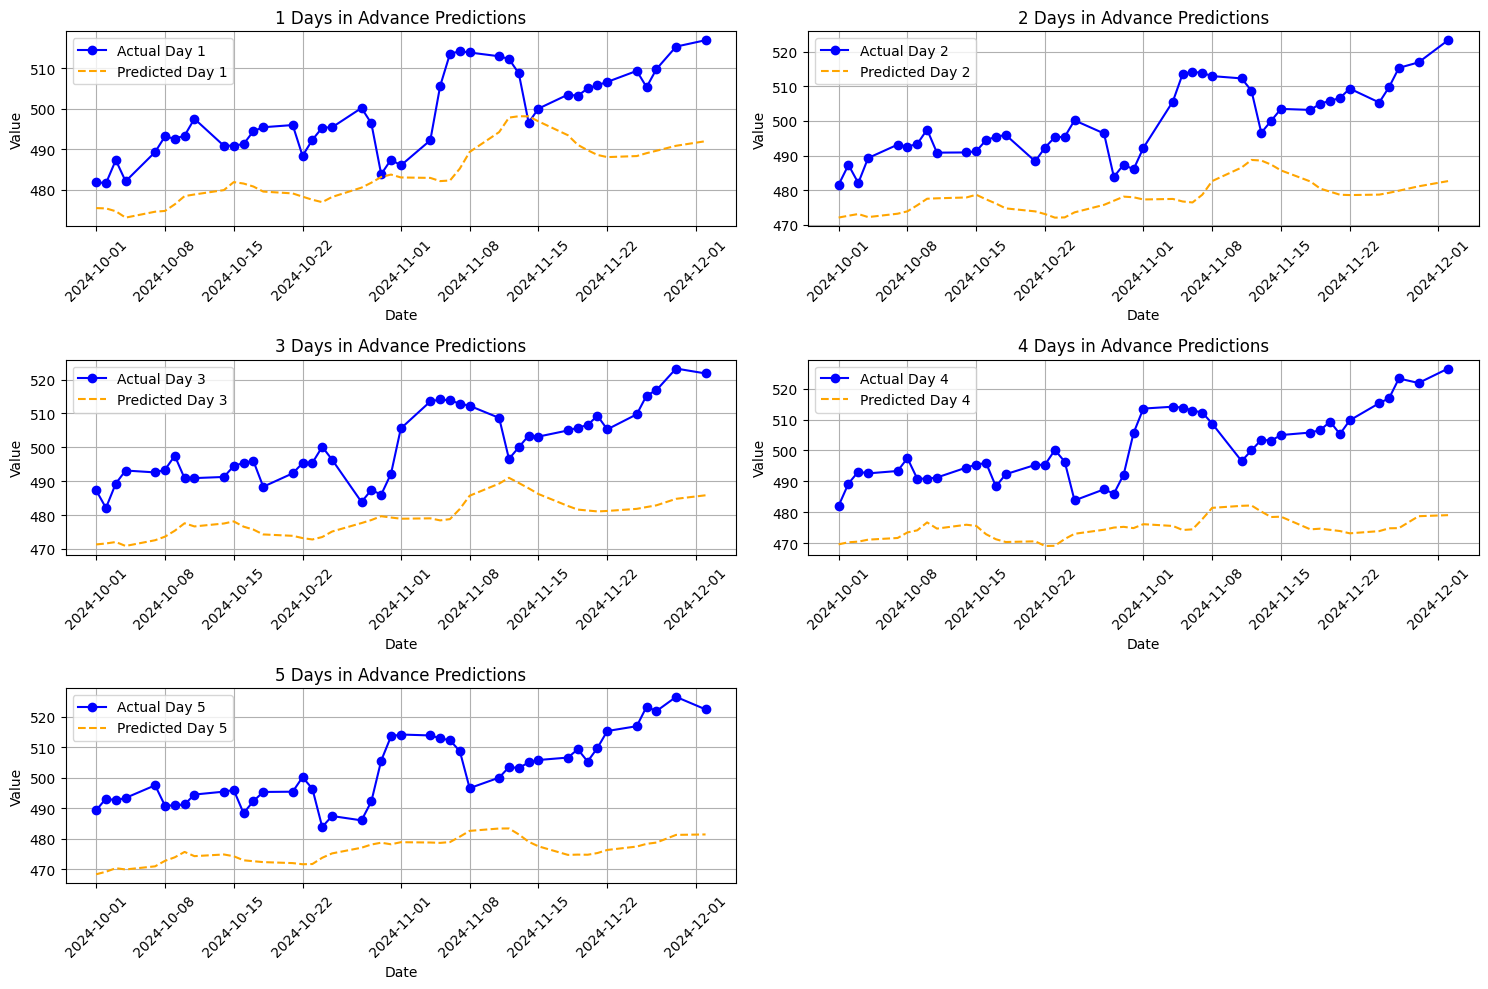

In [85]:
#5 Day Plot
# Assuming test_dates are the dates corresponding to X_test
num_days = 5  # Number of days ahead predictions
test_dates = pd.DataFrame(time_published_test)  # Example dates

y_test_original = sc_y.inverse_transform(y_test)
y_pred_original = sc_y.inverse_transform(y_pred)

# Create DataFrames for easier handling
y_test_df = pd.DataFrame(y_test_original, index=test_dates, columns=[f"Day {i+1}" for i in range(num_days)])
y_pred_df = pd.DataFrame(y_pred_original, index=test_dates, columns=[f"Day {i+1}" for i in range(num_days)])

# Plot each day individually
plt.figure(figsize=(15, 10))

for i in range(num_days):
    plt.subplot(3, 2, i + 1)  # Create a grid of 3 rows, 2 columns
    plt.xticks(rotation=45)
    plt.plot(test_dates, y_test_df.iloc[:, i], label=f"Actual Day {i+1}", color="blue", linestyle="-", marker="o")
    plt.plot(test_dates, y_pred_df.iloc[:, i], label=f"Predicted Day {i+1}", color="orange", linestyle="--")
    plt.title(f"{i+1} Days in Advance Predictions")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[495.2315  485.6603  489.58334 483.01993 484.25015]]


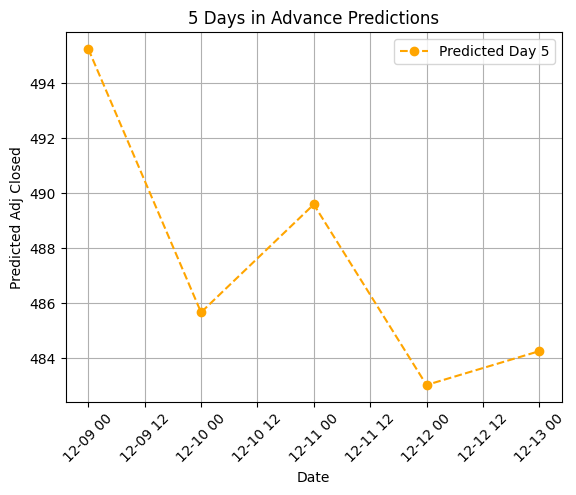

In [86]:
#Future 5 Days Plot
start_date = datetime(2024, 12, 9)
end_date = datetime(2024, 12, 13)

datetime_list = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

future_dates = np.array(datetime_list)

last_y_pred = model.predict(last_X.reshape(1, 30, NUM_FEATURES))
last_y_pred_original = sc_y.inverse_transform(last_y_pred)
print(last_y_pred_original)

plt.xticks(rotation=45)
plt.plot(future_dates, last_y_pred_original.reshape(5,), label=f"Predicted Day {i+1}", color="orange", linestyle="--", marker="o")
plt.title(f"{i+1} Days in Advance Predictions")
plt.xlabel("Date")
plt.ylabel("Predicted Adj Closed")
plt.legend()
plt.grid()